In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt
import warnings
import matplotlib_fontja
warnings.filterwarnings('ignore')

# =============================================================================
# データ取得関数
# =============================================================================

def get_sp500_data(years=10):
    """S&P500の過去データを取得"""
    try:
        ticker = "^GSPC"
        data = yf.download(ticker, period=f"{years}y", interval="1mo")
        returns = data['Close'].pct_change().dropna()
        current_price = data['Close'][-1]
        
        print(f"取得したデータ: {len(returns)}ヶ月分")
        print(f"現在価格: ${current_price:.2f}")
        
        return returns.values, current_price
    except Exception as e:
        print(f"データ取得エラー: {e}")
        # サンプルデータで代替
        np.random.seed(42)
        monthly_returns = np.random.normal(0.01, 0.04, 120)
        current_price = 4500
        print("サンプルデータを使用")
        return monthly_returns, current_price

# =============================================================================
# オプション価格計算
# =============================================================================

def black_scholes_call(S, K, T, r, sigma):
    """Black-Scholesモデルでコールオプション価格を計算"""
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    call_price = S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    return call_price

def setup_options(current_price, rf=0.01, sigma=0.20, T=1/12, N_c=5):
    """オプションの行使価格とプレミアムを設定"""
    # Moneynessを0.9から1.0まで
    moneyness = np.linspace(0.9, 1.0, N_c)
    strike_prices = current_price * moneyness
    
    # Black-Scholesでオプション価格計算
    option_prices = np.array([
        black_scholes_call(current_price, K, T, rf, sigma)
        for K in strike_prices
    ])
    
    print("オプション設定:")
    for i, (K, C) in enumerate(zip(strike_prices, option_prices)):
        print(f"  オプション{i+1}: 行使価格=${K:.2f}, プレミアム=${C:.2f}")
    
    return strike_prices, option_prices

# =============================================================================
# シミュレーション関数
# =============================================================================

def simulate_asset_prices(current_price, monthly_returns, n_simulations=1000):
    """リターンをシミュレーション"""
    # 過去の月次リターンからランダムサンプリング
    simulated_returns = np.random.choice(monthly_returns, n_simulations)
    
    # 満期時の価格
    S_T = current_price * (1 + simulated_returns)
    
    print(f"シミュレーション完了: {n_simulations}回")
    return S_T

def calculate_portfolio_returns(p, current_price, S_T, strike_prices, option_prices, rf=0.01, T=1/12):
    """ポートフォリオリターンを計算"""
    n_sim = len(S_T)
    returns = np.zeros(n_sim)
    
    for i in range(n_sim):
        # オプション支払い計算
        option_payoff = 0
        for j in range(len(p)):
            premium_income = option_prices[j] * np.exp(rf * T)
            option_exercise = max(S_T[i] - strike_prices[j], 0)
            option_payoff += p[j] * (premium_income - option_exercise)
        
        # トータルリターン
        returns[i] = (S_T[i] - current_price + option_payoff) / current_price
    
    return returns

# =============================================================================
# 最適化関数
# =============================================================================

def optimize_variance(current_price, S_T, strike_prices, option_prices, 
                     risk_aversion=0.5, rf=0.01, T=1/12):
    """分散最小化"""
    N_c = len(strike_prices)
    
    def objective(p):
        returns = calculate_portfolio_returns(p, current_price, S_T, strike_prices, option_prices, rf, T)
        variance = np.var(returns, ddof=1)
        expected_return = np.mean(returns)
        return risk_aversion * variance - (1 - risk_aversion) * expected_return
    
    # 制約条件
    constraints = [{'type': 'ineq', 'fun': lambda p: 1 - np.sum(p)}]
    bounds = [(0, 1) for _ in range(N_c)]
    p0 = np.ones(N_c) / N_c * 0.5
    
    result = minimize(objective, p0, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def optimize_semivariance(current_price, S_T, strike_prices, option_prices, 
                         risk_aversion=0.5, rf=0.01, T=1/12):
    """半分散最小化"""
    N_c = len(strike_prices)
    rf_return = np.exp(rf * T) - 1
    
    def objective(p):
        returns = calculate_portfolio_returns(p, current_price, S_T, strike_prices, option_prices, rf, T)
        # 半分散計算（リスクフリーレート以下の偏差のみ）
        downside_deviations = np.minimum(returns - rf_return, 0)
        semivariance = np.mean(downside_deviations**2)
        expected_return = np.mean(returns)
        return risk_aversion * semivariance - (1 - risk_aversion) * expected_return
    
    constraints = [{'type': 'ineq', 'fun': lambda p: 1 - np.sum(p)}]
    bounds = [(0, 1) for _ in range(N_c)]
    p0 = np.ones(N_c) / N_c * 0.5
    
    result = minimize(objective, p0, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def optimize_cvar(current_price, S_T, strike_prices, option_prices, 
                 risk_aversion=0.5, rf=0.01, T=1/12, alpha=0.95):
    """CVaR最小化"""
    N_c = len(strike_prices)
    
    def objective(p):
        returns = calculate_portfolio_returns(p, current_price, S_T, strike_prices, option_prices, rf, T)
        # CVaR計算
        sorted_returns = np.sort(returns)
        n_worst = int((1 - alpha) * len(returns))
        cvar = -np.mean(sorted_returns[:n_worst])  # 負の値にして損失として表現
        expected_return = np.mean(returns)
        return risk_aversion * cvar - (1 - risk_aversion) * expected_return
    
    constraints = [{'type': 'ineq', 'fun': lambda p: 1 - np.sum(p)}]
    bounds = [(0, 1) for _ in range(N_c)]
    p0 = np.ones(N_c) / N_c * 0.5
    
    result = minimize(objective, p0, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# =============================================================================
# 結果分析関数
# =============================================================================

def analyze_results(result, strategy_name, current_price, S_T, strike_prices, option_prices, rf=0.01, T=1/12):
    """結果分析"""
    if result.success:
        p_optimal = result.x
        returns = calculate_portfolio_returns(p_optimal, current_price, S_T, strike_prices, option_prices, rf, T)
        
        print(f"\n=== {strategy_name} 最適化結果 ===")
        print(f"最適化成功: {result.success}")
        print(f"目的関数値: {result.fun:.6f}")
        
        print("\n最適write-buy比率:")
        for i, p in enumerate(p_optimal):
            if p > 0.001:  # 0.1%以上のポジションのみ表示
                print(f"  オプション{i+1} (K=${strike_prices[i]:.0f}): {p:.3f}")
        
        print(f"\n戦略統計:")
        print(f"期待リターン: {np.mean(returns):.4f} ({np.mean(returns)*100:.2f}%)")
        print(f"標準偏差: {np.std(returns):.4f} ({np.std(returns)*100:.2f}%)")
        print(f"VaR(95%): {np.percentile(returns, 5):.4f} ({np.percentile(returns, 5)*100:.2f}%)")
        
        # CVaR計算
        sorted_returns = np.sort(returns)
        n_worst = int(0.05 * len(returns))
        cvar = np.mean(sorted_returns[:n_worst])
        print(f"CVaR(95%): {cvar:.4f} ({cvar*100:.2f}%)")
        
        return p_optimal, returns
    else:
        print(f"{strategy_name} 最適化失敗: {result.message}")
        return None, None

# =============================================================================
# 可視化関数
# =============================================================================

def plot_results(results_dict, strike_prices, option_prices, current_price):
    """結果をプロット"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # 最適ポートフォリオ比率
    strategies = list(results_dict.keys())
    colors = ['blue', 'red', 'green']
    N_c = len(strike_prices)
    
    for i, (strategy, (p_opt, returns)) in enumerate(results_dict.items()):
        if p_opt is not None:
            ax1.bar(np.arange(N_c) + i*0.25, p_opt, 0.25, 
                   label=strategy, alpha=0.7, color=colors[i])
    
    ax1.set_xlabel('オプション番号')
    ax1.set_ylabel('Write-Buy比率')
    ax1.set_title('最適ポートフォリオ構成')
    ax1.legend()
    ax1.set_xticks(np.arange(N_c))
    ax1.set_xticklabels([f'K={k:.0f}' for k in strike_prices])
    
    # リターン分布
    for i, (strategy, (p_opt, returns)) in enumerate(results_dict.items()):
        if returns is not None:
            ax2.hist(returns*100, bins=50, alpha=0.6, label=strategy, color=colors[i])
    
    ax2.set_xlabel('リターン (%)')
    ax2.set_ylabel('頻度')
    ax2.set_title('リターン分布')
    ax2.legend()
    ax2.axvline(0, color='black', linestyle='--', alpha=0.5)
    
    # リスク・リターン散布図
    risk_return_data = []
    for strategy, (p_opt, returns) in results_dict.items():
        if returns is not None:
            risk_return_data.append({
                'strategy': strategy,
                'return': np.mean(returns),
                'risk': np.std(returns)
            })
    
    if risk_return_data:
        df_rr = pd.DataFrame(risk_return_data)
        ax3.scatter(df_rr['risk']*100, df_rr['return']*100, s=100, c=colors[:len(df_rr)])
        for i, row in df_rr.iterrows():
            ax3.annotate(row['strategy'], 
                       (row['risk']*100, row['return']*100),
                       xytext=(5, 5), textcoords='offset points')
        
        ax3.set_xlabel('リスク (標準偏差 %)')
        ax3.set_ylabel('期待リターン (%)')
        ax3.set_title('リスク・リターン散布図')
        ax3.grid(True, alpha=0.3)
    
    # オプション価格
    ax4.plot(strike_prices, option_prices, 'o-', linewidth=2, markersize=8)
    ax4.axvline(current_price, color='red', linestyle='--', alpha=0.7, label='現在価格')
    ax4.set_xlabel('行使価格 ($)')
    ax4.set_ylabel('オプション価格 ($)')
    ax4.set_title('オプション価格')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# =============================================================================
# メイン実行関数
# =============================================================================



In [6]:
import pickle
# 1. データ取得
monthly_returns, current_price = get_sp500_data()

with open('monthly_returns.pkl', 'wb') as f:
    pickle.dump(monthly_returns, f)
with open('current_price.pkl', 'wb') as f:
    pickle.dump(current_price, f)


[*********************100%***********************]  1 of 1 completed

データ取得エラー: -1
サンプルデータを使用


In [8]:
with open('monthly_returns.pkl', 'rb') as f:
    monthly_returns = pickle.load(f)
with open('current_price.pkl', 'rb') as f:
    current_price = pickle.load(f)

オプション設定:
  オプション1: 行使価格=$4050.00, プレミアム=$456.56
  オプション2: 行使価格=$4162.50, プレミアム=$350.86
  オプション3: 行使価格=$4275.00, プレミアム=$253.84
  オプション4: 行使価格=$4387.50, プレミアム=$170.69
  オプション5: 行使価格=$4500.00, プレミアム=$105.48
シミュレーション完了: 1000回

最適化実行中...

=== 分散最小化 最適化結果 ===
最適化成功: True
目的関数値: -0.005329

最適write-buy比率:
  オプション5 (K=$4500): 1.000

戦略統計:
期待リターン: 0.0111 (1.11%)
標準偏差: 0.0204 (2.04%)
VaR(95%): -0.0371 (-3.71%)
CVaR(95%): -0.0496 (-4.96%)

=== 半分散最小化 最適化結果 ===
最適化成功: True
目的関数値: -0.005442

最適write-buy比率:
  オプション5 (K=$4500): 1.000

戦略統計:
期待リターン: 0.0111 (1.11%)
標準偏差: 0.0204 (2.04%)
VaR(95%): -0.0371 (-3.71%)
CVaR(95%): -0.0496 (-4.96%)

=== CVaR最小化 最適化結果 ===
最適化成功: True
目的関数値: -0.001168

最適write-buy比率:
  オプション1 (K=$4050): 0.530
  オプション2 (K=$4162): 0.470

戦略統計:
期待リターン: 0.0021 (0.21%)
標準偏差: 0.0010 (0.10%)
VaR(95%): 0.0022 (0.22%)
CVaR(95%): 0.0002 (0.02%)


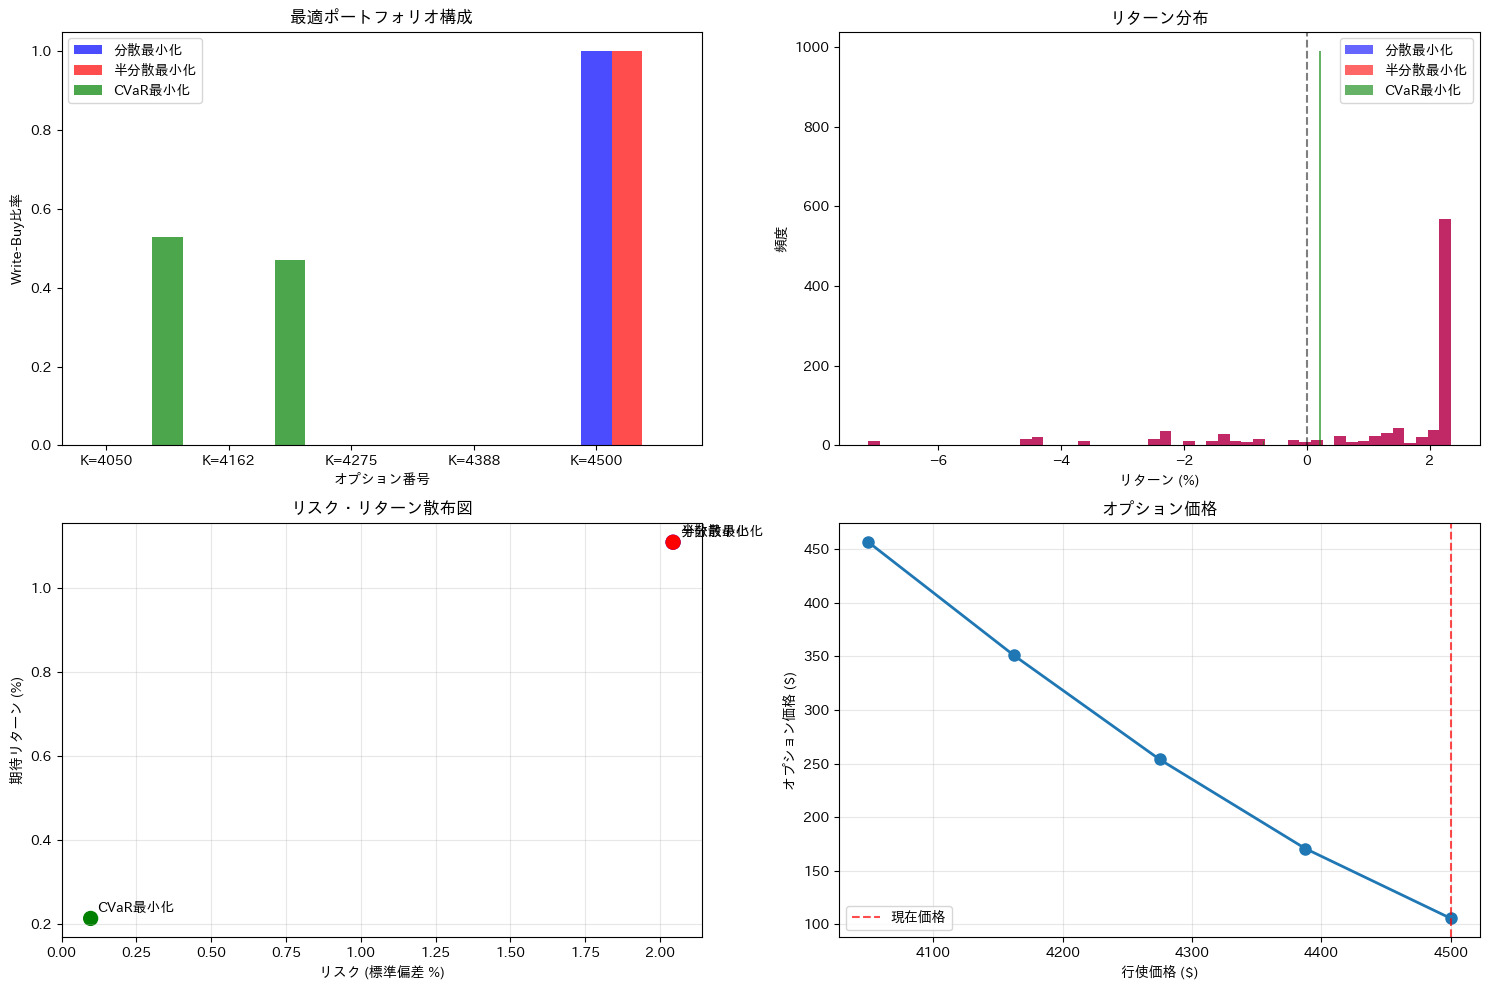


=== 実行完了 ===


{'current_price': 4500,
 'strike_prices': array([4050. , 4162.5, 4275. , 4387.5, 4500. ]),
 'option_prices': array([456.55620935, 350.85730868, 253.84308905, 170.68810736,
        105.47569475]),
 'S_T': array([4362.69039834, 4192.2593777 , 4288.54532648, 4610.09448451,
        4599.27852162, 4591.98994899, 4428.87844417, 4454.68373215,
        4461.58481529, 4540.22750242, 4443.78824474, 4598.30164987,
        4538.55131296, 4604.62741765, 4428.87844417, 4187.23759537,
        4418.6304431 , 4661.58393686, 4290.78533376, 4604.62741765,
        4325.24814301, 4381.55566641, 4637.38813796, 4532.03817812,
        4381.55566641, 4290.78533376, 4281.56730934, 4610.05120899,
        4475.68518953, 4515.9685719 , 4542.57049955, 4580.43502246,
        4305.9265112 , 4609.28026287, 4400.59009154, 4634.40854754,
        4461.58481529, 4719.3560983 , 4393.94084582, 4449.64316332,
        4227.65277203, 4557.15507684, 4436.6928098 , 4486.02081361,
        4575.84629061, 4545.9204222 , 4829.258306

In [9]:
risk_aversion=0.5
n_simulations=1000
rf=0.01
sigma=0.20
T=1/12
N_c=5


    

# 2. オプション設定
strike_prices, option_prices = setup_options(current_price, rf, sigma, T, N_c)

# 3. シミュレーション
S_T = simulate_asset_prices(current_price, monthly_returns, n_simulations)

# 4. 各戦略の最適化
results = {}

print("\n最適化実行中...")

# 分散最小化
result_var = optimize_variance(current_price, S_T, strike_prices, option_prices, risk_aversion, rf, T)
p_var, returns_var = analyze_results(result_var, "分散最小化", current_price, S_T, strike_prices, option_prices, rf, T)
results['分散最小化'] = (p_var, returns_var)

# 半分散最小化
result_semi = optimize_semivariance(current_price, S_T, strike_prices, option_prices, risk_aversion, rf, T)
p_semi, returns_semi = analyze_results(result_semi, "半分散最小化", current_price, S_T, strike_prices, option_prices, rf, T)
results['半分散最小化'] = (p_semi, returns_semi)

# CVaR最小化
result_cvar = optimize_cvar(current_price, S_T, strike_prices, option_prices, risk_aversion, rf, T)
p_cvar, returns_cvar = analyze_results(result_cvar, "CVaR最小化", current_price, S_T, strike_prices, option_prices, rf, T)
results['CVaR最小化'] = (p_cvar, returns_cvar)

# 5. 結果プロット
plot_results(results, strike_prices, option_prices, current_price)

print("\n=== 実行完了 ===")
{
    'current_price': current_price,
    'strike_prices': strike_prices,
    'option_prices': option_prices,
    'S_T': S_T
}

In [4]:
monthly_returns

array([ 0.02986857,  0.00446943,  0.03590754,  0.07092119,  0.00063387,
        0.00063452,  0.07316851,  0.04069739, -0.00877898,  0.0317024 ,
       -0.00853671, -0.00862919,  0.01967849, -0.06653121, -0.05899671,
       -0.0124915 , -0.03051324,  0.02256989, -0.02632096, -0.04649215,
        0.06862595,  0.00096895,  0.01270113, -0.04698993, -0.01177531,
        0.0144369 , -0.03603974,  0.02502792, -0.01402555, -0.00166775,
       -0.01406826,  0.08409113,  0.00946011, -0.03230844,  0.0429018 ,
       -0.03883375,  0.01835454, -0.0683868 , -0.04312744,  0.01787445,
        0.03953866,  0.01685473,  0.00537407, -0.00204415, -0.04914088,
       -0.01879377, -0.00842555,  0.05228489,  0.02374473, -0.06052161,
        0.02296336, -0.00540329, -0.01707688,  0.03446705,  0.05123998,
        0.0472512 , -0.0235687 , -0.0023685 ,  0.02325054,  0.04902181,
       -0.00916697,  0.00257364, -0.0342534 , -0.03784826,  0.04250103,
        0.0642496 ,  0.0071196 ,  0.05014132,  0.02446544, -0.01

# プロテクティブプット

In [14]:
def get_sp500_data(years=10):
    """S&P500の過去データを取得"""
    try:
        ticker = "^GSPC"
        data = yf.download(ticker, period=f"{years}y", interval="1mo")
        returns = data['Close'].pct_change().dropna()
        current_price = data['Close'][-1]
        
        print(f"取得したデータ: {len(returns)}ヶ月分")
        print(f"現在価格: ${current_price:.2f}")
        
        return returns.values, current_price
    except Exception as e:
        print(f"データ取得エラー: {e}")
        np.random.seed(42)
        monthly_returns = np.random.normal(0.01, 0.04, 120)
        current_price = 4500
        print("サンプルデータを使用")
        return monthly_returns, current_price

# =============================================================================
# オプション価格計算（プット用）
# =============================================================================

def black_scholes_put(S, K, T, r, sigma):
    """Black-Scholesモデルでプットオプション価格を計算"""
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    put_price = K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

def setup_put_options(current_price, rf=0.01, sigma=0.20, T=1/12, N_c=5):
    """プットオプションの行使価格とプレミアムを設定"""
    # プロテクティブプット用：ITM〜ATMの範囲（moneyness 0.85-1.0）
    moneyness = np.linspace(0.85, 1.0, N_c)
    strike_prices = current_price * moneyness
    
    # Black-Scholesでプット価格計算
    put_prices = np.array([
        black_scholes_put(current_price, K, T, rf, sigma)
        for K in strike_prices
    ])
    
    print("プットオプション設定:")
    for i, (K, P) in enumerate(zip(strike_prices, put_prices)):
        moneyness_pct = (K/current_price - 1) * 100
        print(f"  プット{i+1}: 行使価格=${K:.2f} ({moneyness_pct:+.1f}%), プレミアム=${P:.2f}")
    
    return strike_prices, put_prices

# =============================================================================
# シミュレーション関数（共通）
# =============================================================================

def simulate_asset_prices(current_price, monthly_returns, n_simulations=1000):
    """リターンをシミュレーション"""
    simulated_returns = np.random.choice(monthly_returns, n_simulations)
    S_T = current_price * (1 + simulated_returns)
    
    print(f"シミュレーション完了: {n_simulations}回")
    return S_T

# =============================================================================
# プロテクティブプット戦略のリターン計算
# =============================================================================

def calculate_protective_put_returns(p, current_price, S_T, strike_prices, put_prices, rf=0.01, T=1/12):
    """
    プロテクティブプット戦略のリターンを計算
    
    正しいリターン式：
    初期投資 = S_0 + Σ p_j * P_j
    r = (S_T + Σ p_j * max(K_j - S_T, 0) - 初期投資) / 初期投資
    
    構成要素：
    - 満期時価値: S_T + プット内在価値
    - 初期投資: 株式購入 + プットプレミアム支払い
    """
    n_sim = len(S_T)
    returns = np.zeros(n_sim)
    
    # 初期投資額計算：株式 + プットプレミアム
    put_premium_cost = np.sum(p * put_prices)
    initial_investment = current_price + put_premium_cost
    
    print(f"初期投資額: ${initial_investment:.2f} (株式: ${current_price:.2f} + プット: ${put_premium_cost:.2f})")
    
    for i in range(n_sim):
        # 満期時のポートフォリオ価値
        stock_value = S_T[i]
        
        # プットオプションの内在価値のみ（プレミアムは初期投資に含まれている）
        put_value = 0
        for j in range(len(p)):
            put_intrinsic = max(strike_prices[j] - S_T[i], 0)
            put_value += p[j] * put_intrinsic
        
        # トータルリターン計算
        final_value = stock_value + put_value
        returns[i] = (final_value - initial_investment) / initial_investment
    
    return returns

# =============================================================================
# プロテクティブプット最適化関数
# =============================================================================

def optimize_put_variance(current_price, S_T, strike_prices, put_prices, 
                         risk_aversion=0.5, rf=0.01, T=1/12):
    """プロテクティブプット：分散最小化"""
    N_c = len(strike_prices)
    
    def objective(p):
        returns = calculate_protective_put_returns(p, current_price, S_T, strike_prices, put_prices, rf, T)
        variance = np.var(returns, ddof=1)
        expected_return = np.mean(returns)
        return risk_aversion * variance - (1 - risk_aversion) * expected_return
    
    constraints = [{'type': 'ineq', 'fun': lambda p: 1 - np.sum(p)}]  # Σp_j ≤ 1
    bounds = [(0, 1) for _ in range(N_c)]
    p0 = np.ones(N_c) / N_c * 0.5
    
    result = minimize(objective, p0, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def optimize_put_semivariance(current_price, S_T, strike_prices, put_prices, 
                             risk_aversion=0.5, rf=0.01, T=1/12):
    """プロテクティブプット：半分散最小化"""
    N_c = len(strike_prices)
    rf_return = np.exp(rf * T) - 1
    
    def objective(p):
        returns = calculate_protective_put_returns(p, current_price, S_T, strike_prices, put_prices, rf, T)
        # 半分散計算（リスクフリーレート以下の偏差のみ）
        downside_deviations = np.minimum(returns - rf_return, 0)
        semivariance = np.mean(downside_deviations**2)
        expected_return = np.mean(returns)
        return risk_aversion * semivariance - (1 - risk_aversion) * expected_return
    
    constraints = [{'type': 'ineq', 'fun': lambda p: 1 - np.sum(p)}]
    bounds = [(0, 1) for _ in range(N_c)]
    p0 = np.ones(N_c) / N_c * 0.5
    
    result = minimize(objective, p0, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def optimize_put_cvar(current_price, S_T, strike_prices, put_prices, 
                     risk_aversion=0.5, rf=0.01, T=1/12, alpha=0.95):
    """プロテクティブプット：CVaR最小化"""
    N_c = len(strike_prices)
    
    def objective(p):
        returns = calculate_protective_put_returns(p, current_price, S_T, strike_prices, put_prices, rf, T)
        # CVaR計算
        sorted_returns = np.sort(returns)
        n_worst = int((1 - alpha) * len(returns))
        cvar = -np.mean(sorted_returns[:n_worst])  # 損失として表現
        expected_return = np.mean(returns)
        return risk_aversion * cvar - (1 - risk_aversion) * expected_return
    
    constraints = [{'type': 'ineq', 'fun': lambda p: 1 - np.sum(p)}]
    bounds = [(0, 1) for _ in range(N_c)]
    p0 = np.ones(N_c) / N_c * 0.5
    
    result = minimize(objective, p0, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# =============================================================================
# 結果分析関数
# =============================================================================

def analyze_put_results(result, strategy_name, current_price, S_T, strike_prices, put_prices, rf=0.01, T=1/12):
    """プロテクティブプット結果分析"""
    if result.success:
        p_optimal = result.x
        returns = calculate_protective_put_returns(p_optimal, current_price, S_T, strike_prices, put_prices, rf, T)
        
        # コスト分析
        put_premium_cost = np.sum(p_optimal * put_prices)
        initial_investment = current_price + put_premium_cost
        protection_cost_pct = (put_premium_cost / current_price) * 100
        
        print(f"\n=== {strategy_name} 最適化結果 ===")
        print(f"最適化成功: {result.success}")
        print(f"目的関数値: {result.fun:.6f}")
        
        print(f"\nコスト分析:")
        print(f"株式投資: ${current_price:.2f}")
        print(f"プット保険料: ${put_premium_cost:.2f} ({protection_cost_pct:.2f}%)")
        print(f"総初期投資: ${initial_investment:.2f}")
        
        print("\n最適プット購入比率:")
        for i, p in enumerate(p_optimal):
            if p > 0.001:  # 0.1%以上のポジションのみ表示
                moneyness = strike_prices[i] / current_price
                cost = p * put_prices[i]
                print(f"  プット{i+1} (K=${strike_prices[i]:.0f}, {moneyness:.3f}): {p:.3f} (コスト: ${cost:.2f})")
        
        print(f"\n戦略統計:")
        print(f"期待リターン: {np.mean(returns):.4f} ({np.mean(returns)*100:.2f}%)")
        print(f"標準偏差: {np.std(returns):.4f} ({np.std(returns)*100:.2f}%)")
        print(f"VaR(95%): {np.percentile(returns, 5):.4f} ({np.percentile(returns, 5)*100:.2f}%)")
        
        # CVaR計算
        sorted_returns = np.sort(returns)
        n_worst = int(0.05 * len(returns))
        cvar = np.mean(sorted_returns[:n_worst])
        print(f"CVaR(95%): {cvar:.4f} ({cvar*100:.2f}%)")
        
        # プロテクション効果の分析
        stock_only_returns = (S_T - current_price) / current_price
        downside_scenarios = S_T < current_price
        if np.any(downside_scenarios):
            avg_downside_stock = np.mean(stock_only_returns[downside_scenarios])
            avg_downside_protected = np.mean(returns[downside_scenarios])
            protection_benefit = avg_downside_protected - avg_downside_stock
            print(f"下落時保護効果: {protection_benefit:.4f} ({protection_benefit*100:.2f}%)")
        
        return p_optimal, returns
    else:
        print(f"{strategy_name} 最適化失敗: {result.message}")
        return None, None

# =============================================================================
# 可視化関数
# =============================================================================

def plot_put_results(results_dict, strike_prices, put_prices, current_price, S_T):
    """プロテクティブプット結果をプロット"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # 最適ポートフォリオ比率
    strategies = list(results_dict.keys())
    colors = ['blue', 'red', 'green']
    N_c = len(strike_prices)
    
    for i, (strategy, (p_opt, returns)) in enumerate(results_dict.items()):
        if p_opt is not None:
            ax1.bar(np.arange(N_c) + i*0.25, p_opt, 0.25, 
                   label=strategy, alpha=0.7, color=colors[i])
    
    ax1.set_xlabel('プットオプション番号')
    ax1.set_ylabel('プット購入比率')
    ax1.set_title('最適プロテクティブプット構成')
    ax1.legend()
    ax1.set_xticks(np.arange(N_c))
    ax1.set_xticklabels([f'K={k:.0f}' for k in strike_prices])
    
    # リターン分布比較（株式のみ vs プロテクティブプット）
    stock_only_returns = (S_T - current_price) / current_price
    ax2.hist(stock_only_returns*100, bins=50, alpha=0.4, label='株式のみ', color='gray')
    
    for i, (strategy, (p_opt, returns)) in enumerate(results_dict.items()):
        if returns is not None:
            ax2.hist(returns*100, bins=50, alpha=0.6, label=f'PP: {strategy}', color=colors[i])
    
    ax2.set_xlabel('リターン (%)')
    ax2.set_ylabel('頻度')
    ax2.set_title('リターン分布比較')
    ax2.legend()
    ax2.axvline(0, color='black', linestyle='--', alpha=0.5)
    
    # 下落シナリオでの保護効果
    downside_scenarios = S_T < current_price
    if np.any(downside_scenarios):
        stock_downside = stock_only_returns[downside_scenarios] * 100
        
        ax3.hist(stock_downside, bins=30, alpha=0.4, label='株式のみ', color='gray')
        
        for i, (strategy, (p_opt, returns)) in enumerate(results_dict.items()):
            if returns is not None:
                protected_downside = returns[downside_scenarios] * 100
                ax3.hist(protected_downside, bins=30, alpha=0.6, 
                        label=f'PP: {strategy}', color=colors[i])
        
        ax3.set_xlabel('下落時リターン (%)')
        ax3.set_ylabel('頻度')
        ax3.set_title('下落シナリオでの保護効果')
        ax3.legend()
    
    # プットオプション価格
    moneyness = strike_prices / current_price
    ax4.plot(moneyness, put_prices, 'o-', linewidth=2, markersize=8, label='プット価格')
    ax4.axvline(1.0, color='red', linestyle='--', alpha=0.7, label='ATM')
    ax4.set_xlabel('Moneyness (K/S)')
    ax4.set_ylabel('プット価格 ($)')
    ax4.set_title('プットオプション価格構造')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


[*********************100%***********************]  1 of 1 completed


データ取得エラー: -1
サンプルデータを使用
プットオプション設定:
  プット1: 行使価格=$3825.00 (-15.0%), プレミアム=$0.17
  プット2: 行使価格=$3993.75 (-11.3%), プレミアム=$1.66
  プット3: 行使価格=$4162.50 (-7.5%), プレミアム=$9.89
  プット4: 行使価格=$4331.25 (-3.7%), プレミアム=$37.87
  プット5: 行使価格=$4500.00 (+0.0%), プレミアム=$101.73
シミュレーション完了: (1000,)回

最適化実行中...
初期投資額: $4515.13 (株式: $4500.00 + プット: $15.13)
初期投資額: $4515.13 (株式: $4500.00 + プット: $15.13)
初期投資額: $4515.13 (株式: $4500.00 + プット: $15.13)
初期投資額: $4515.13 (株式: $4500.00 + プット: $15.13)
初期投資額: $4515.13 (株式: $4500.00 + プット: $15.13)
初期投資額: $4515.13 (株式: $4500.00 + プット: $15.13)
初期投資額: $4514.56 (株式: $4500.00 + プット: $14.56)
初期投資額: $4514.56 (株式: $4500.00 + プット: $14.56)
初期投資額: $4514.56 (株式: $4500.00 + プット: $14.56)
初期投資額: $4514.56 (株式: $4500.00 + プット: $14.56)
初期投資額: $4514.56 (株式: $4500.00 + プット: $14.56)
初期投資額: $4514.56 (株式: $4500.00 + プット: $14.56)
初期投資額: $4511.68 (株式: $4500.00 + プット: $11.68)
初期投資額: $4511.68 (株式: $4500.00 + プット: $11.68)
初期投資額: $4511.68 (株式: $4500.00 + プット: $11.68)
初期投資額: $4511.68 (株式: $4500.00 + プット: 

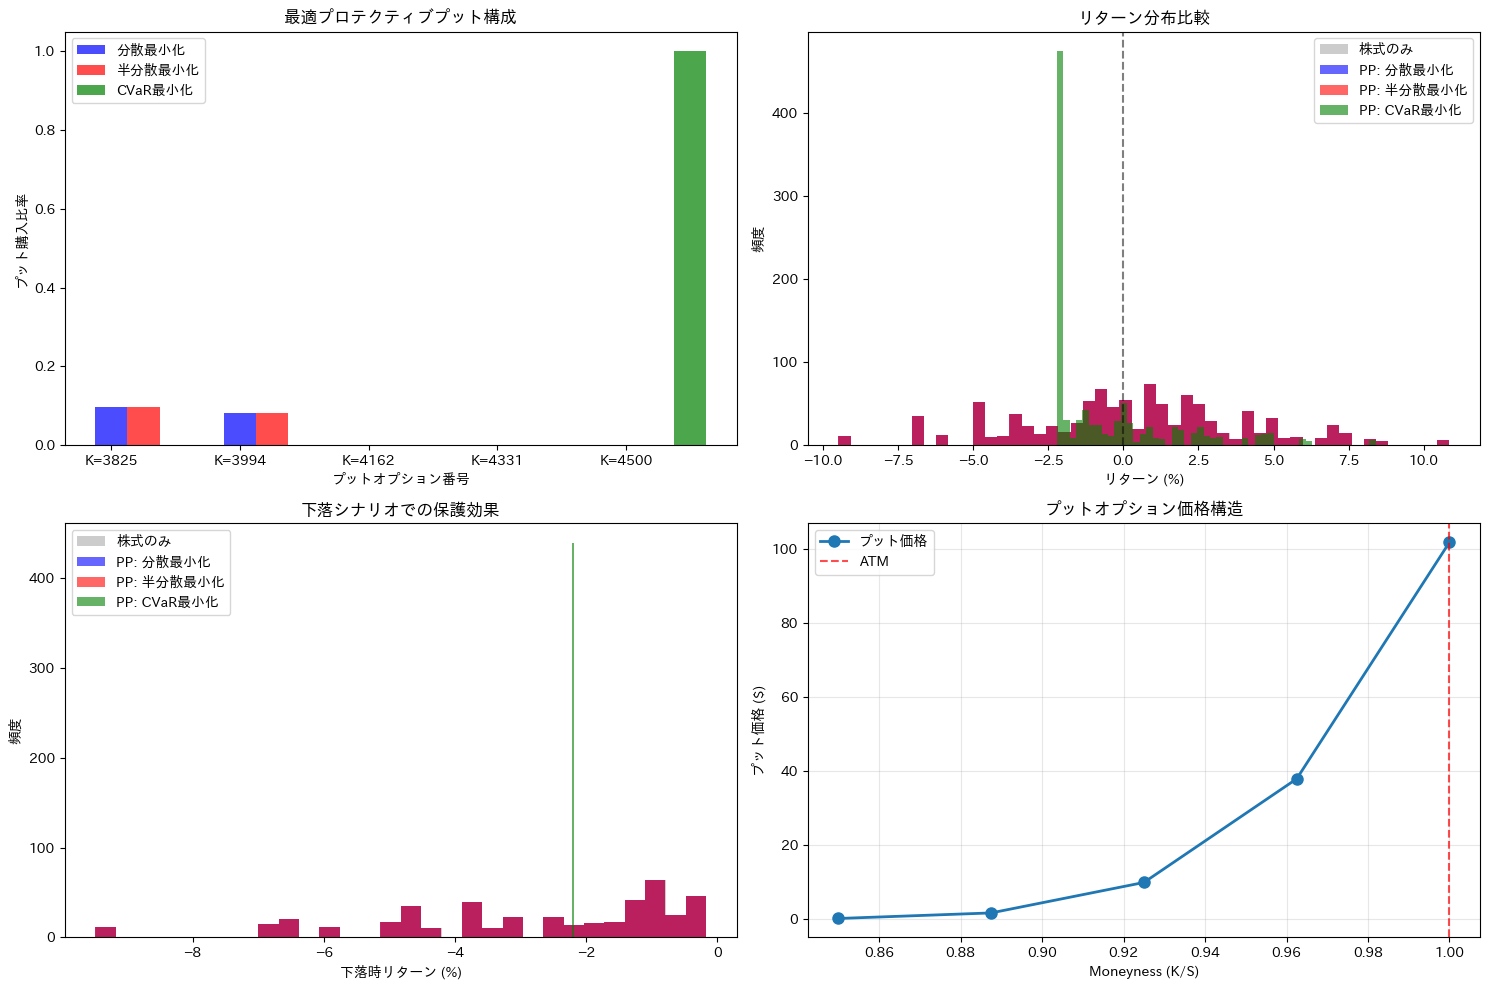


=== プロテクティブプット最適化完了 ===


In [15]:
risk_aversion=0.5
n_simulations=1000,
rf=0.01
sigma=0.20
T=1/12
N_c=5

# 1. データ取得
monthly_returns, current_price = get_sp500_data()

# 2. プットオプション設定
strike_prices, put_prices = setup_put_options(current_price, rf, sigma, T, N_c)

# 3. シミュレーション
S_T = simulate_asset_prices(current_price, monthly_returns, n_simulations)

# 4. 各戦略の最適化
results = {}

print("\n最適化実行中...")

# 分散最小化
result_var = optimize_put_variance(current_price, S_T, strike_prices, put_prices, risk_aversion, rf, T)
p_var, returns_var = analyze_put_results(result_var, "分散最小化", current_price, S_T, strike_prices, put_prices, rf, T)
results['分散最小化'] = (p_var, returns_var)

# 半分散最小化
result_semi = optimize_put_semivariance(current_price, S_T, strike_prices, put_prices, risk_aversion, rf, T)
p_semi, returns_semi = analyze_put_results(result_semi, "半分散最小化", current_price, S_T, strike_prices, put_prices, rf, T)
results['半分散最小化'] = (p_semi, returns_semi)

# CVaR最小化
result_cvar = optimize_put_cvar(current_price, S_T, strike_prices, put_prices, risk_aversion, rf, T)
p_cvar, returns_cvar = analyze_put_results(result_cvar, "CVaR最小化", current_price, S_T, strike_prices, put_prices, rf, T)
results['CVaR最小化'] = (p_cvar, returns_cvar)

# 5. 結果プロット
plot_put_results(results, strike_prices, put_prices, current_price, S_T)

print("\n=== プロテクティブプット最適化完了 ===")
